In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
import os
import copy
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
# num_classes = ds_info.features["label"].num_classes
# base_model = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224,224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation='softmax')
# ])


In [5]:
num_classes = ds_info.features["label"].num_classes
is_train = True
if is_train:
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,    # Imagenet 분류기  fully connected layer 제거
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',      # GAP를 적용  
    )
    x = base_model.output
    preds = keras.layers.Dense(num_classes, activation='softmax')(x)
    base_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

In [9]:
base_model_path = "~/aiffel/class_activation_map/cam_model1.h5"
if is_train:
    base_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_base_model = base_model.fit(
        ds_train_norm,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=20,
        validation_data=ds_val_norm,
        verbose=1,
        use_multiprocessing=True,
    )


    base_model.save(base_model_path)
else:
    base_model = keras.models.load_model(base_model_path)

Epoch 1/20
750/750 [==============================] - 157s 199ms/step - loss: 2.2571 - accuracy: 0.4346 - val_loss: 3.4787 - val_accuracy: 0.1924
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 0.6482 - accuracy: 0.8295 - val_loss: 1.3106 - val_accuracy: 0.6251
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.1717 - accuracy: 0.9754 - val_loss: 1.1213 - val_accuracy: 0.6799
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0564 - accuracy: 0.9973 - val_loss: 1.0020 - val_accuracy: 0.7107
Epoch 5/20
750/750 [==============================] - 168s 224ms/step - loss: 0.0279 - accuracy: 0.9987 - val_loss: 0.9886 - val_accuracy: 0.7212
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0207 - accuracy: 0.9992 - val_loss: 1.0409 - val_accuracy: 0.7176
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0153 - accuracy: 0.9994 - val_loss: 0.9859 -

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


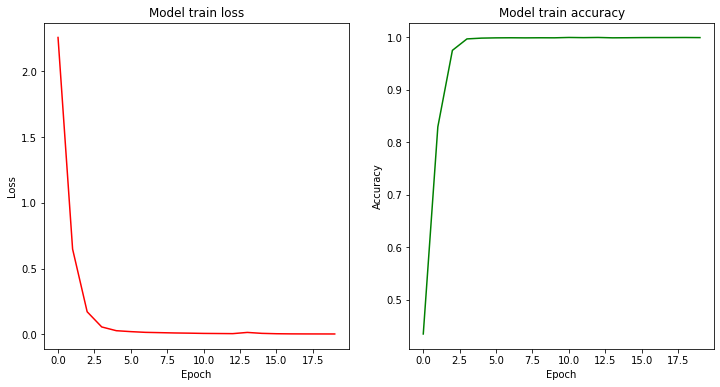

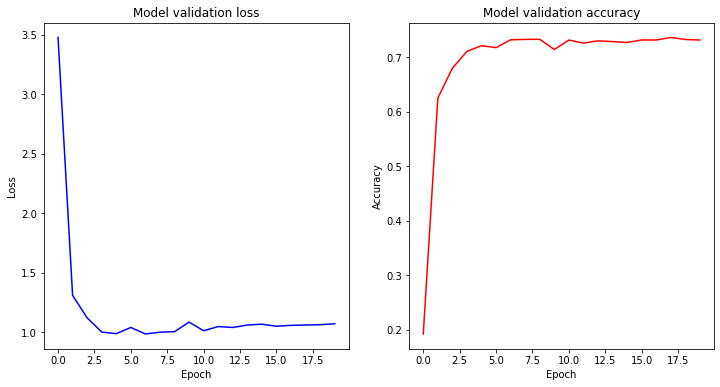

In [13]:
if is_train:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(history_base_model.history['loss'], 'r')
    ax1.set_title('Model train loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history_base_model.history['accuracy'], 'g')
    ax2.set_title('Model train accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    # fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
    plt.show()
    
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

    ax3.plot(history_base_model.history['val_loss'], 'b')
#     ax3.set_ylim([0.00, 2]) 
    ax3.set_title('Model validation loss')
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')

    ax4.plot(history_base_model.history['val_accuracy'], 'r')
    ax4.set_title('Model validation accuracy')
    ax4.set_ylabel('Accuracy')
    ax4.set_xlabel('Epoch')

    # fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
    plt.show()

In [14]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## CAM 구현하기

In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

80


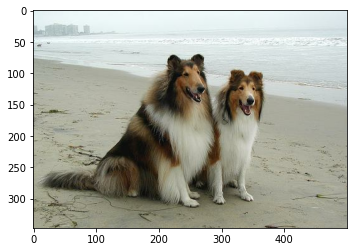

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

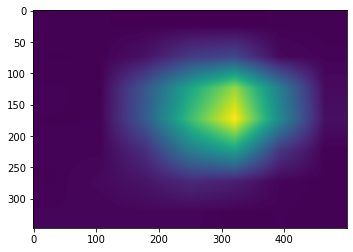

In [17]:
cam_image = generate_cam(base_model, item)
plt.imshow(cam_image)

In [18]:
def visualize_cam_on_image(image, cam_image, alpha):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

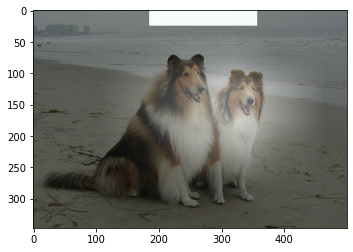

In [19]:
# visualize_cam_on_image() 함수 사용

# type(item['image'].numpy())

# origin_image = item['image'].numpy().astype(np.uint8)

# type(item['image'].numpy())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8) # 0보다 작은 값도 박스가 그려져서 수정필요 

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image, 0.5)
plt.imshow(blended_image)

## Grad-CAM 구현하기

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

#### 2.만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

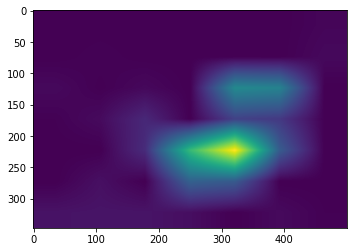

In [21]:
layer_name = 'conv5_block3_out'  
# layer_name = 'conv4_block1_out '
grad_cam_image = generate_grad_cam(base_model, layer_name, item)
plt.imshow(grad_cam_image)
plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

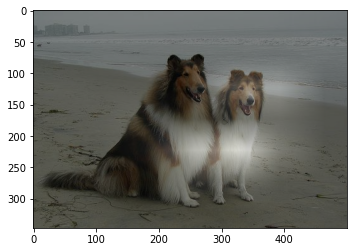

In [22]:
type(item['image'])

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image, 0.5)
plt.imshow(blended_image)

### 바운딩 박스 구하기

제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

1)에서 얻은 바운딩 박스를 시각화해 보세요.

In [23]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [24]:
cam_rect = get_bbox(cam_image)

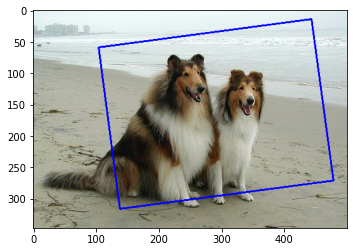

In [25]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [26]:
grad_cam_rect = get_bbox(grad_cam_image)

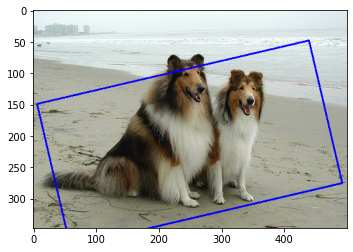

In [27]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU 구하기

정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [28]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [29]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [30]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
get_iou(cam_pred_bbox, item['objects']['bbox'][0])

0.33445528841199

In [31]:
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

0.43055557286994817

In [32]:
# iou 구하기
def getGrad_CAM_Iou(base_model, layer_name, item, alpha=0.5, box_th=0.25):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8)) # 2 x 2 이미지 틀 생성
    axes = axes.ravel() # 2차원 배열을 1차원으로 변환
    origin_image = item['image'].astype(np.uint8) # org_img
    
    axes[0].imshow(origin_image) # img 설정
    axes[0].axis('off') # 축 제거
    axes[0].set_title('org_img') # title 설정
    
    grad_cam_image = generate_grad_cam(base_model, layer_name, item) # grad_cam 이미지 
    
    axes[1].imshow(grad_cam_image) # img 설정
    axes[1].axis('off') # 축 제거
    axes[1].set_title('grad_cam_img') # title 설정
    
    
    grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8) # Grad-CAM 이미지를 3채널로 변환하고 0~255 범위로 스케일링
    blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image, alpha) # org img랑 grad_cam 합성
    
    axes[2].imshow(blended_image) # img 설정
    axes[2].axis('off') # 축 제거
    axes[2].set_title('blended_img') # title 설정
    
    grad_cam_rect = get_bbox(grad_cam_image, score_thresh=box_th)
    box_image = cv2.drawContours(origin_image, [grad_cam_rect], 0, (0,0,255), 2)
    
    axes[3].imshow(box_image) # img 설정
    axes[3].axis('off') # 축 제거
    axes[3].set_title('box_img') # title 설정
    
    plt.tight_layout()
    plt.show()
    
    grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
    
    return  get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

In [35]:
item = get_one(ds_train)

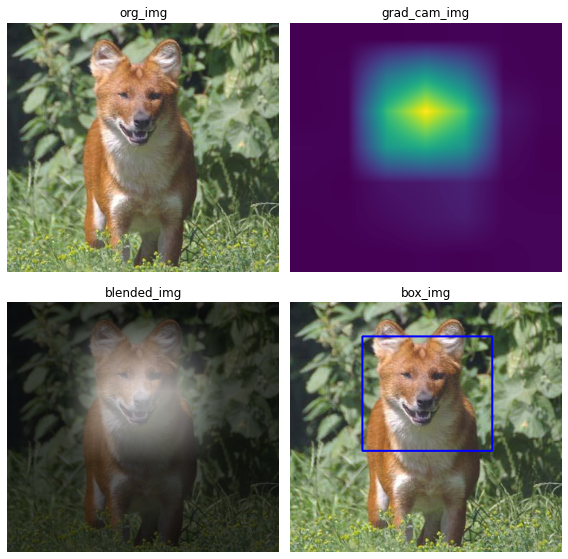

iou =  0.46908544440091293


In [36]:
layer_name = 'conv5_block3_out'
box_th = 0.25
alpha = 0.7
iou = getGrad_CAM_Iou(base_model, layer_name, item, alpha, box_th)
print('iou = ', iou)

|평가문항|상세기준|결과|
|--------|--------|--------|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|안정적으로 수렴하였습니다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|넵!|
|3.인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|넵!|